# Preoperative Oral Paracetamol in Paediatric Tonsillectomies
## Service Evaluation Analysis

This notebook analyzes the effectiveness of preoperative oral paracetamol administration in paediatric tonsillectomies at SGH Southampton. 

**Objectives:**
1. Demonstrate practice change over time following intervention
2. Prove non-inferiority of oral paracetamol through pain scores and rescue medication analysis
3. Identify barriers to implementation from staff survey data

## 1. Import Required Libraries

In [1]:
# Core data analysis libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical testing
from scipy import stats
from scipy.stats import mannwhitneyu, chi2_contingency, ttest_ind

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Matplotlib is building the font cache; this may take a moment.


Libraries imported successfully!


## 2. Load and Explore Clinical Data

Load the clinical data from the first sheet of the Excel workbook. This contains 42 observations with 11 columns of patient data including paracetamol administration status, pain scores, and rescue medication requirements.

In [2]:
# Load clinical data (first sheet) - using first 11 columns as specified
file_path = 'Paracetamol_ServiceEval_Data.xlsx'

# Load the Excel file and get sheet names
excel_file = pd.ExcelFile(file_path)
print("Available sheets:", excel_file.sheet_names)

# Load clinical data (first sheet, first 11 columns)
clinical_data = pd.read_excel(file_path, sheet_name=0, usecols=range(11))

# Display basic information
print(f"\nDataset Shape: {clinical_data.shape}")
print(f"Number of Observations: {clinical_data.shape[0]}")
print(f"Number of Variables: {clinical_data.shape[1]}")
print("\nColumn Names:")
print(clinical_data.columns.tolist())
print("\nData Types:")
print(clinical_data.dtypes)

Available sheets: ['Clinical Data', 'Staff Survey']

Dataset Shape: (42, 11)
Number of Observations: 42
Number of Variables: 11

Column Names:
['Study ID', 'Age (years)', 'Sex (M/F)', 'Date of Surgery', 'Paracetamol route (oral/IV)', 'Timing of administration (min)', 'Pain score (0-10)', 'Rescue analgesia required (Y/N)', 'Type of rescue analgesia ', 'Dose of rescue analgesia ', 'Adverse effects (Nausea, Vomiting, Sedation, None)']

Data Types:
Study ID                                                      object
Age (years)                                                    int64
Sex (M/F)                                                     object
Date of Surgery                                       datetime64[ns]
Paracetamol route (oral/IV)                                   object
Timing of administration (min)                                 int64
Pain score (0-10)                                              int64
Rescue analgesia required (Y/N)                               object

In [3]:
# Preview the clinical data
print("First 10 rows of Clinical Data:")
clinical_data.head(10)

First 10 rows of Clinical Data:


,Study ID,Age (years),Sex (M/F),Date of Surgery,Paracetamol route (oral/IV),Timing of administration (min),Pain score (0-10),Rescue analgesia required (Y/N),Type of rescue analgesia,Dose of rescue analgesia,"Adverse effects (Nausea, Vomiting, Sedation, None)"
0,P001,2,M,2025-09-22,IV,0,0,No,NaN,NaN,NaN
1,P002,5,F,2025-09-22,IV,0,2,No,NaN,NaN,NaN
2,P003,10,M,2025-09-22,Oral,-43,4,No,NaN,NaN,NaN
3,P004,11,F,2025-09-22,Oral,-31,0,No,NaN,NaN,NaN
4,P005,2,M,2025-09-29,IV,0,0,No,NaN,NaN,NaN
5,P006,3,M,2025-09-29,IV,0,0,No,NaN,NaN,NaN
6,P007,4,F,2025-09-29,IV,0,0,No,NaN,NaN,NaN
7,P008,5,M,2025-09-30,IV,0,0,No,NaN,NaN,NaN
8,P009,6,M,2025-09-30,IV,0,2,Yes,Oramorph,2.5milligrams,NaN
9,P010,3,F,2025-10-06,IV,0,0,No,NaN,NaN,NaN


## 3. Load and Explore Staff Survey Data

Load the second sheet containing staff survey responses to understand the barriers to implementing preoperative oral paracetamol.

In [4]:
# Load staff survey data (second sheet)
survey_data = pd.read_excel(file_path, sheet_name=1)

# Display basic information
print(f"Staff Survey Shape: {survey_data.shape}")
print(f"Number of Responses: {survey_data.shape[0]}")
print(f"Number of Questions: {survey_data.shape[1]}")
print("\nColumn Names:")
for i, col in enumerate(survey_data.columns):
    print(f"  {i+1}. {col}")

print("\n--- Staff Survey Preview ---")
survey_data.head()

Staff Survey Shape: (11, 14)
Number of Responses: 11
Number of Questions: 14

Column Names:
  1. ID
  2. Email
  3. What is your role in the care of paediatric patients? (Select all that apply)
  4. How many years have you worked in this role?
  5. Are you aware of a protocol or guideline in you hospital regarding preoperative oral paracetamol administration for paediatric patients?
  6. Do you routinely administer or witness the administration of oral paracetamol preoperatively for these patients?
  7. If paracetamol is not administered preoperatively, what are the most common reasons? (Select all that apply)

  8. What challenges do you face when attempting to administer oral paracetamol preoperatively? (select all that apply)
  9. Do you believe there is a clear and consistent approach to administering preoperative oral paracetamol in your department?
  10. If no, what improvements do you think could be made to improve consistency and adherence to preoperative paracetamol administra

,ID,Email,What is your role in the care of paediatric patients? (Select all that apply),How many years have you worked in this role?,Are you aware of a protocol or guideline in you hospital regarding preoperative oral paracetamol administration for paediatric patients?,Do you routinely administer or witness the administration of oral paracetamol preoperatively for these patients?,"If paracetamol is not administered preoperatively, what are the most common reasons? (Select all that apply)\n",What challenges do you face when attempting to administer oral paracetamol preoperatively? (select all that apply),Do you believe there is a clear and consistent approach to administering preoperative oral paracetamol in your department?,"If no, what improvements do you think could be made to improve consistency and adherence to preoperative paracetamol administration? (select all that apply)",What do you think would make it easier to administer oral paracetamol preoperatively?,Do you think parental education on preoperative medication would improve adherence?,Would a standardised preoperative checklist including oral paracetamol administration help improve consistency?,Any additional comments or suggestions on improving preoperative paracetamol administration?
0,1,anonymous,Anaesthetist;,1-5 years,No,Never,Logistical/time constraints in the day ward;,Lack of time in the preoperative workflow;,No,More time allocated in the preoperative workflow;,Get the parents to administer Calpol themselve...,Yes,No,It would make sense to get the parents to do i...
1,2,anonymous,Anaesthetist;,More than 10 years,No,Never,Logistical/time constraints in the day ward;La...,Lack of time in the preoperative workflow;Beli...,No,More time allocated in the preoperative workfl...,Give it in theatre reception when patient arri...,No,No,NaN
2,3,anonymous,Anaesthetist;,More than 10 years,Not sure,Sometimes,Lack of formal protocol ;Concerns about fastin...,Children refusing to take medication orally ;L...,No,Clearer guidelines or protocols;Improved commu...,As part of the protocolised pathway. Parents a...,Yes,Yes,"Patient selection, list order maintained, pare..."
3,4,anonymous,Anaesthetist;,1-5 years,Yes,Sometimes,Logistical/time constraints in the day ward;,Lack of time in the preoperative workflow;Inco...,No,More time allocated in the preoperative workfl...,PGD and for it to be done as routine,Not sure,Yes,NaN
4,5,anonymous,Anaesthetist;,More than 10 years,No,Never,Logistical/time constraints in the day ward;La...,Inconsistency in instructions from different t...,No,Clearer guidelines or protocols;Improved commu...,Paper based OR child's weight already inputted...,Yes,Yes,As above. I was happy to give it myself in th...


## 4. Data Cleaning and Preprocessing

Handle missing values, standardize data types, and prepare the dataset for analysis. Create categorical groupings for oral paracetamol administration status.

In [5]:
# Check for missing values in clinical data
print("Missing Values in Clinical Data:")
print(clinical_data.isnull().sum())
print(f"\nTotal missing values: {clinical_data.isnull().sum().sum()}")

# Display summary statistics
print("\n--- Summary Statistics for Numerical Columns ---")
clinical_data.describe()

Missing Values in Clinical Data:
Study ID                                               0
Age (years)                                            0
Sex (M/F)                                              0
Date of Surgery                                        0
Paracetamol route (oral/IV)                            0
Timing of administration (min)                         0
Pain score (0-10)                                      0
Rescue analgesia required (Y/N)                        0
Type of rescue analgesia                              40
Dose of rescue analgesia                              40
Adverse effects (Nausea, Vomiting, Sedation, None)    42
dtype: int64

Total missing values: 122

--- Summary Statistics for Numerical Columns ---


,Age (years),Date of Surgery,Timing of administration (min),Pain score (0-10),"Adverse effects (Nausea, Vomiting, Sedation, None)"
count,42.000000,42,42.000000,42.000000,0.0
mean,5.309524,2025-10-29 20:34:17.142857216,-25.404762,0.309524,NaN
min,2.000000,2025-09-22 00:00:00,-158.000000,0.000000,NaN
25%,3.000000,2025-10-07 00:00:00,-42.250000,0.000000,NaN
50%,5.000000,2025-10-30 00:00:00,-18.500000,0.000000,NaN
75%,7.000000,2025-11-19 12:00:00,0.000000,0.000000,NaN
max,11.000000,2025-12-02 00:00:00,0.000000,4.000000,NaN
std,2.589737,NaN,30.387786,0.896826,NaN


In [6]:
# Identify key columns - adjust these based on actual column names after loading
# This cell will help identify the relevant columns for analysis

print("Column names and sample values:")
for col in clinical_data.columns:
    print(f"\n{col}:")
    print(f"  Unique values: {clinical_data[col].nunique()}")
    print(f"  Sample: {clinical_data[col].dropna().head(3).tolist()}")

Column names and sample values:

Study ID:
  Unique values: 42
  Sample: ['P001', 'P002', 'P003']

Age (years):
  Unique values: 10
  Sample: [2, 5, 10]

Sex (M/F):
  Unique values: 2
  Sample: ['M', 'F', 'M']

Date of Surgery:
  Unique values: 20
  Sample: [Timestamp('2025-09-22 00:00:00'), Timestamp('2025-09-22 00:00:00'), Timestamp('2025-09-22 00:00:00')]

Paracetamol route (oral/IV):
  Unique values: 3
  Sample: ['IV', 'IV', 'Oral']

Timing of administration (min):
  Unique values: 20
  Sample: [0, 0, -43]

Pain score (0-10):
  Unique values: 4
  Sample: [0, 2, 4]

Rescue analgesia required (Y/N):
  Unique values: 2
  Sample: ['No', 'No', 'No']

Type of rescue analgesia :
  Unique values: 1
  Sample: ['Oramorph', 'Oramorph']

Dose of rescue analgesia :
  Unique values: 2
  Sample: ['2.5milligrams', '3 milligrams']

Adverse effects (Nausea, Vomiting, Sedation, None):
  Unique values: 0
  Sample: []


In [7]:
# Data preprocessing - standardize column names and create analysis groups
# Note: Column names will be adjusted based on actual data after first run

# Create a clean copy for analysis
df = clinical_data.copy()

# Standardize column names (lowercase, replace spaces with underscores)
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('/', '_')
print("Standardized column names:")
print(df.columns.tolist())

# Convert date columns if present
date_cols = [col for col in df.columns if 'date' in col.lower()]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    print(f"\nConverted {col} to datetime")

df.head()

Standardized column names:
['study_id', 'age_(years)', 'sex_(m_f)', 'date_of_surgery', 'paracetamol_route_(oral_iv)', 'timing_of_administration_(min)', 'pain_score_(0-10)', 'rescue_analgesia_required_(y_n)', 'type_of_rescue_analgesia', 'dose_of_rescue_analgesia', 'adverse_effects_(nausea,_vomiting,_sedation,_none)']

Converted date_of_surgery to datetime


,study_id,age_(years),sex_(m_f),date_of_surgery,paracetamol_route_(oral_iv),timing_of_administration_(min),pain_score_(0-10),rescue_analgesia_required_(y_n),type_of_rescue_analgesia,dose_of_rescue_analgesia,"adverse_effects_(nausea,_vomiting,_sedation,_none)"
0,P001,2,M,2025-09-22,IV,0,0,No,NaN,NaN,NaN
1,P002,5,F,2025-09-22,IV,0,2,No,NaN,NaN,NaN
2,P003,10,M,2025-09-22,Oral,-43,4,No,NaN,NaN,NaN
3,P004,11,F,2025-09-22,Oral,-31,0,No,NaN,NaN,NaN
4,P005,2,M,2025-09-29,IV,0,0,No,NaN,NaN,NaN


## 5. Descriptive Statistics for Clinical Outcomes

Calculate comprehensive summary statistics for pain scores, rescue medication usage, and other clinical variables to understand the distribution of outcomes.

In [8]:
# Identify the oral paracetamol column and group data
# Look for columns related to paracetamol, pre-med, oral, etc.
paracetamol_cols = [col for col in df.columns if any(term in col.lower() for term in ['paracetamol', 'oral', 'pre-med', 'premed'])]
print("Potential paracetamol-related columns:", paracetamol_cols)

# Identify pain score columns
pain_cols = [col for col in df.columns if any(term in col.lower() for term in ['pain', 'score', 'vas', 'flacc'])]
print("Potential pain score columns:", pain_cols)

# Identify rescue medication columns
rescue_cols = [col for col in df.columns if any(term in col.lower() for term in ['rescue', 'morphine', 'opioid', 'additional'])]
print("Potential rescue medication columns:", rescue_cols)

Potential paracetamol-related columns: ['paracetamol_route_(oral_iv)']
Potential pain score columns: ['pain_score_(0-10)']
Potential rescue medication columns: ['rescue_analgesia_required_(y_n)', 'type_of_rescue_analgesia', 'dose_of_rescue_analgesia']


In [9]:
# Overall descriptive statistics
print("=" * 60)
print("OVERALL DESCRIPTIVE STATISTICS")
print("=" * 60)

# Numerical summary
numerical_cols = df.select_dtypes(include=[np.number]).columns
print("\n--- Numerical Variables Summary ---")
df[numerical_cols].describe().round(2)

OVERALL DESCRIPTIVE STATISTICS

--- Numerical Variables Summary ---


,age_(years),timing_of_administration_(min),pain_score_(0-10),"adverse_effects_(nausea,_vomiting,_sedation,_none)"
count,42.00,42.00,42.00,0.0
mean,5.31,-25.40,0.31,NaN
std,2.59,30.39,0.90,NaN
min,2.00,-158.00,0.00,NaN
25%,3.00,-42.25,0.00,NaN
50%,5.00,-18.50,0.00,NaN
75%,7.00,0.00,0.00,NaN
max,11.00,0.00,4.00,NaN


In [10]:
# Categorical variable frequency tables
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print("\n--- Categorical Variables Distribution ---")
for col in categorical_cols:
    print(f"\n{col.upper()}:")
    print(df[col].value_counts())
    print(f"  Missing: {df[col].isnull().sum()}")


--- Categorical Variables Distribution ---

STUDY_ID:
study_id
P001    1
P032    1
P024    1
P025    1
P026    1
P027    1
P028    1
P029    1
P030    1
P031    1
P033    1
P002    1
P034    1
P035    1
P036    1
P037    1
P038    1
P039    1
P040    1
P041    1
P023    1
P022    1
P021    1
P020    1
P003    1
P004    1
P005    1
P006    1
P007    1
P008    1
P009    1
P010    1
P011    1
P012    1
P013    1
P014    1
P015    1
P016    1
P017    1
P018    1
P019    1
P042    1
Name: count, dtype: int64
  Missing: 0

SEX_(M_F):
sex_(m_f)
M    21
F    21
Name: count, dtype: int64
  Missing: 0

PARACETAMOL_ROUTE_(ORAL_IV):
paracetamol_route_(oral_iv)
Oral     25
IV       16
Oral      1
Name: count, dtype: int64
  Missing: 0

RESCUE_ANALGESIA_REQUIRED_(Y_N):
rescue_analgesia_required_(y_n)
No     40
Yes     2
Name: count, dtype: int64
  Missing: 0

TYPE_OF_RESCUE_ANALGESIA:
type_of_rescue_analgesia
Oramorph    2
Name: count, dtype: int64
  Missing: 40

DOSE_OF_RESCUE_ANALGESIA:
dose_of_r

## 6. Compare Pain Scores: Oral vs Non-Oral Paracetamol Groups

Visualize the difference in pain scores between patients who received oral paracetamol preoperatively and those who did not, to demonstrate non-inferiority.

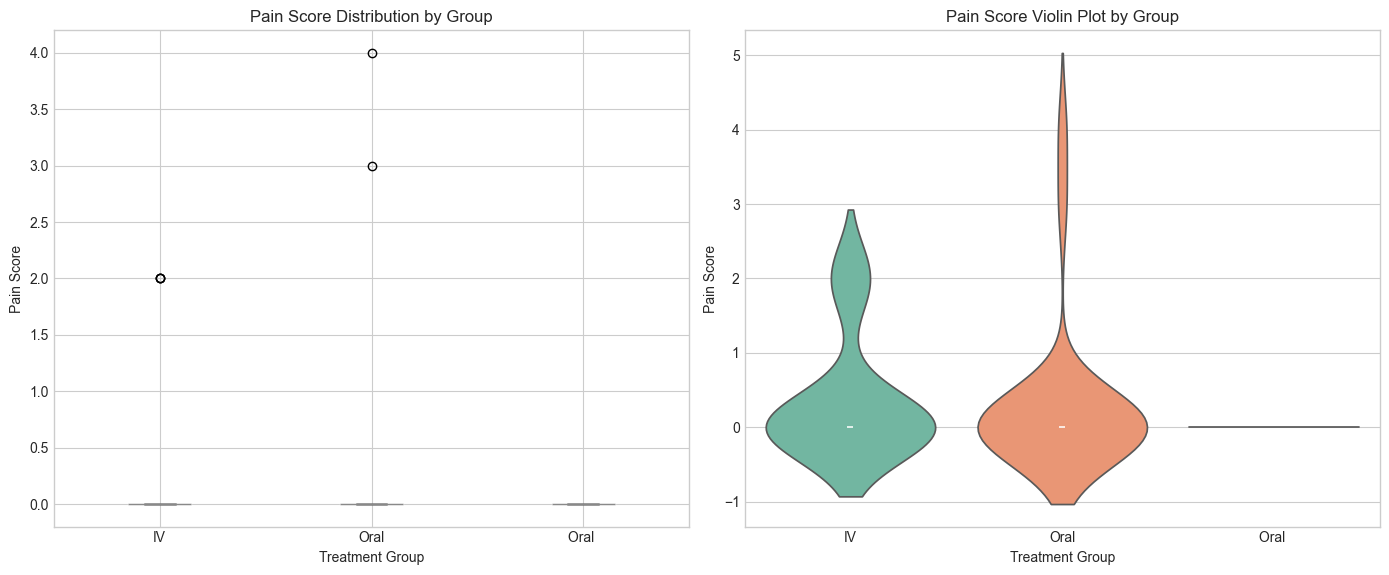

In [11]:
# Create comparison visualizations for pain scores
# Note: Adjust column names based on actual data after running previous cells

# Find the main grouping column (oral paracetamol yes/no)
# and pain score column(s) from the identified columns above

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# This is a template - column names will be adjusted based on actual data
# Assuming we find a grouping column and pain column

# Plot 1: Box plot comparison
# If you have specific columns, replace 'group_col' and 'pain_col' below
try:
    # Attempt to find and use the paracetamol grouping
    group_col = [col for col in df.columns if any(term in col.lower() for term in ['oral', 'paracetamol', 'group'])]
    pain_col = [col for col in df.columns if any(term in col.lower() for term in ['pain', 'score'])]
    
    if group_col and pain_col:
        # Box plot
        ax1 = axes[0]
        df.boxplot(column=pain_col[0], by=group_col[0], ax=ax1)
        ax1.set_title('Pain Score Distribution by Group')
        ax1.set_xlabel('Treatment Group')
        ax1.set_ylabel('Pain Score')
        plt.suptitle('')  # Remove automatic title
        
        # Violin plot using seaborn
        ax2 = axes[1]
        sns.violinplot(data=df, x=group_col[0], y=pain_col[0], ax=ax2, palette='Set2')
        ax2.set_title('Pain Score Violin Plot by Group')
        ax2.set_xlabel('Treatment Group')
        ax2.set_ylabel('Pain Score')
    else:
        print("Note: Please identify the correct column names for grouping and pain scores")
        print("Available columns:", df.columns.tolist())
except Exception as e:
    print(f"Visualization pending - please verify column names after loading data")
    print(f"Error: {e}")

plt.tight_layout()
plt.show()

In [ ]:
# Summary statistics by group
print("=" * 60)
print("PAIN SCORES BY TREATMENT GROUP")
print("=" * 60)

try:
    if group_col and pain_col:
        grouped_stats = df.groupby(group_col[0])[pain_col[0]].agg([
            'count', 'mean', 'std', 'median', 'min', 'max'
        ]).round(2)
        grouped_stats.columns = ['N', 'Mean', 'Std Dev', 'Median', 'Min', 'Max']
        print(grouped_stats)
        
        # Calculate 95% Confidence Intervals
        print("\n--- 95% Confidence Intervals for Mean Pain Score ---")
        for group in df[group_col[0]].dropna().unique():
            group_data = df[df[group_col[0]] == group][pain_col[0]].dropna()
            n = len(group_data)
            mean = group_data.mean()
            std_err = group_data.std() / np.sqrt(n)
            ci_95 = (mean - 1.96 * std_err, mean + 1.96 * std_err)
            print(f"{group}: {mean:.2f} (95% CI: {ci_95[0]:.2f} - {ci_95[1]:.2f})")
except:
    print("Please run previous cells to identify column names first")

## 7. Analyze Rescue Medication Requirements

Compare the frequency and timing of rescue medication between groups. Lower rescue medication requirements in the oral paracetamol group would support its effectiveness.

Rescue medication columns found: ['rescue_analgesia_required_(y_n)', 'type_of_rescue_analgesia', 'dose_of_rescue_analgesia']


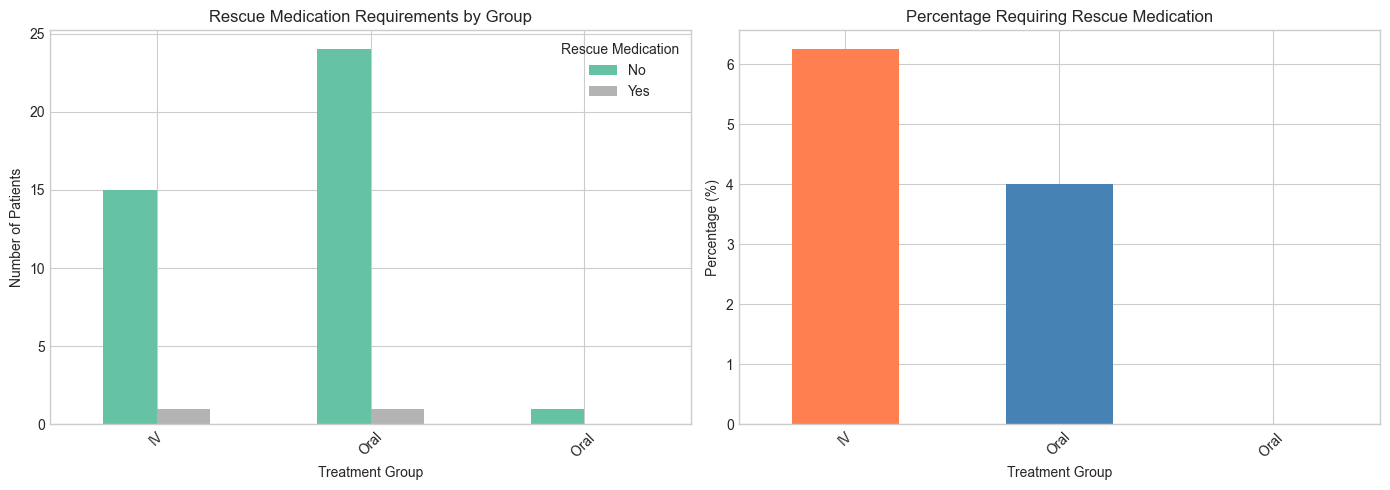


--- Contingency Table: Rescue Medication by Group ---
rescue_analgesia_required_(y_n)  No  Yes  All
paracetamol_route_(oral_iv)                  
IV                               15    1   16
Oral                             24    1   25
Oral                              1    0    1
All                              40    2   42


In [12]:
# Analyze rescue medication requirements
# Find rescue medication columns
rescue_cols = [col for col in df.columns if any(term in col.lower() 
               for term in ['rescue', 'morphine', 'opioid', 'additional', 'fentanyl', 'codeine'])]

print("Rescue medication columns found:", rescue_cols)

# Create contingency table if possible
try:
    if group_col and rescue_cols:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Count of rescue medication by group
        ax1 = axes[0]
        rescue_by_group = df.groupby(group_col[0])[rescue_cols[0]].value_counts().unstack(fill_value=0)
        rescue_by_group.plot(kind='bar', ax=ax1, colormap='Set2')
        ax1.set_title('Rescue Medication Requirements by Group')
        ax1.set_xlabel('Treatment Group')
        ax1.set_ylabel('Number of Patients')
        ax1.legend(title='Rescue Medication')
        ax1.tick_params(axis='x', rotation=45)
        
        # Percentage comparison
        ax2 = axes[1]
        rescue_pct = df.groupby(group_col[0])[rescue_cols[0]].apply(
            lambda x: (x == 'Yes').sum() / len(x) * 100 if x.dtype == 'object' else x.mean() * 100
        )
        rescue_pct.plot(kind='bar', ax=ax2, color=['coral', 'steelblue'])
        ax2.set_title('Percentage Requiring Rescue Medication')
        ax2.set_xlabel('Treatment Group')
        ax2.set_ylabel('Percentage (%)')
        ax2.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Contingency table
        print("\n--- Contingency Table: Rescue Medication by Group ---")
        contingency = pd.crosstab(df[group_col[0]], df[rescue_cols[0]], margins=True)
        print(contingency)
except Exception as e:
    print(f"Note: Please verify column names - {e}")
    print("Available columns:", df.columns.tolist())

## 8. Run Chart: Oral Paracetamol Administration Over Time

Create a run chart to demonstrate how the practice of administering oral paracetamol has changed over time following the service evaluation intervention.

Date columns found: ['date_of_surgery']


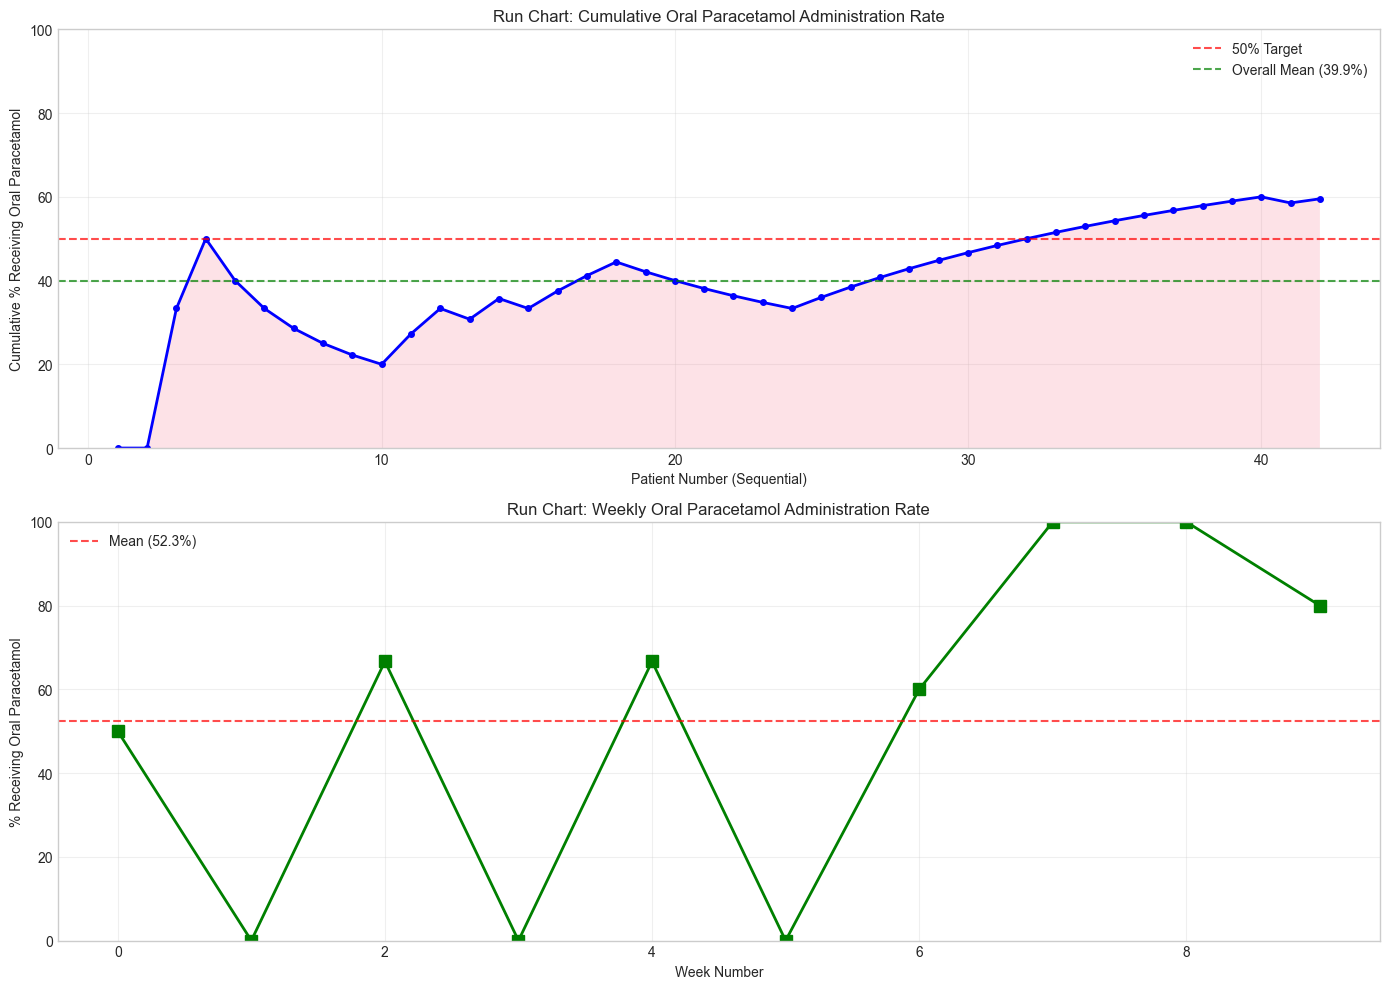


--- Run Chart Summary Statistics ---
Total Patients: 42
Patients receiving oral paracetamol: 25
Overall rate: 59.5%
Median run: 40.0%


In [13]:
# Create Run Chart showing practice change over time
# Find date column
date_cols = [col for col in df.columns if any(term in col.lower() for term in ['date', 'time', 'day'])]
print("Date columns found:", date_cols)

try:
    if date_cols and group_col:
        # Sort by date
        df_sorted = df.sort_values(by=date_cols[0])
        
        fig, axes = plt.subplots(2, 1, figsize=(14, 10))
        
        # Run Chart 1: Sequential patient number with oral paracetamol status
        ax1 = axes[0]
        df_sorted = df_sorted.reset_index(drop=True)
        df_sorted['patient_number'] = range(1, len(df_sorted) + 1)
        
        # Convert to binary (1 for oral paracetamol, 0 for no)
        oral_binary = df_sorted[group_col[0]].apply(
            lambda x: 1 if str(x).lower() in ['yes', 'y', 'oral', '1', 'true'] else 0
        )
        
        # Calculate running proportion
        df_sorted['cumulative_oral'] = oral_binary.cumsum()
        df_sorted['running_proportion'] = df_sorted['cumulative_oral'] / df_sorted['patient_number']
        
        ax1.plot(df_sorted['patient_number'], df_sorted['running_proportion'] * 100, 
                 'b-o', linewidth=2, markersize=4)
        ax1.axhline(y=50, color='r', linestyle='--', label='50% Target', alpha=0.7)
        ax1.axhline(y=df_sorted['running_proportion'].mean() * 100, color='g', 
                    linestyle='--', label=f'Overall Mean ({df_sorted["running_proportion"].mean()*100:.1f}%)', alpha=0.7)
        ax1.fill_between(df_sorted['patient_number'], 0, df_sorted['running_proportion'] * 100, alpha=0.2)
        ax1.set_xlabel('Patient Number (Sequential)')
        ax1.set_ylabel('Cumulative % Receiving Oral Paracetamol')
        ax1.set_title('Run Chart: Cumulative Oral Paracetamol Administration Rate')
        ax1.legend(loc='best')
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(0, 100)
        
        # Run Chart 2: By date if available
        ax2 = axes[1]
        if df_sorted[date_cols[0]].notna().sum() > 0:
            # Group by date/week
            df_sorted['week'] = pd.to_datetime(df_sorted[date_cols[0]]).dt.to_period('W')
            weekly_rate = df_sorted.groupby('week').apply(
                lambda x: (x[group_col[0]].apply(
                    lambda v: 1 if str(v).lower() in ['yes', 'y', 'oral', '1', 'true'] else 0
                ).sum() / len(x)) * 100
            )
            
            ax2.plot(range(len(weekly_rate)), weekly_rate.values, 'g-s', linewidth=2, markersize=8)
            ax2.axhline(y=weekly_rate.mean(), color='r', linestyle='--', 
                        label=f'Mean ({weekly_rate.mean():.1f}%)', alpha=0.7)
            ax2.set_xlabel('Week Number')
            ax2.set_ylabel('% Receiving Oral Paracetamol')
            ax2.set_title('Run Chart: Weekly Oral Paracetamol Administration Rate')
            ax2.legend(loc='best')
            ax2.grid(True, alpha=0.3)
            ax2.set_ylim(0, 100)
        
        plt.tight_layout()
        plt.show()
        
        # Print run chart statistics
        print("\n--- Run Chart Summary Statistics ---")
        print(f"Total Patients: {len(df_sorted)}")
        print(f"Patients receiving oral paracetamol: {oral_binary.sum()}")
        print(f"Overall rate: {oral_binary.mean()*100:.1f}%")
        print(f"Median run: {df_sorted['running_proportion'].median()*100:.1f}%")
        
except Exception as e:
    print(f"Note: Run chart requires date and group columns - {e}")

## 9. Statistical Testing for Non-Inferiority

Perform statistical tests to demonstrate that oral paracetamol is non-inferior to standard practice:
- **Mann-Whitney U test** or **t-test** for pain score comparison
- **Chi-square test** for rescue medication rates
- Calculate effect sizes and confidence intervals

In [14]:
# Statistical Testing for Non-Inferiority
print("=" * 70)
print("STATISTICAL ANALYSIS: NON-INFERIORITY TESTING")
print("=" * 70)

try:
    if group_col and pain_col:
        # Split data by group
        groups = df[group_col[0]].dropna().unique()
        print(f"\nGroups found: {groups}")
        
        # Assume first group is oral paracetamol, second is control
        # Adjust based on actual data
        group_data = {}
        for g in groups:
            group_data[g] = df[df[group_col[0]] == g][pain_col[0]].dropna()
            print(f"\n{g}: n={len(group_data[g])}, mean={group_data[g].mean():.2f}, std={group_data[g].std():.2f}")
        
        if len(groups) >= 2:
            group1_data = group_data[groups[0]]
            group2_data = group_data[groups[1]]
            
            print("\n" + "-" * 50)
            print("PAIN SCORE COMPARISON")
            print("-" * 50)
            
            # Shapiro-Wilk test for normality
            print("\n1. Normality Test (Shapiro-Wilk):")
            for g in groups:
                if len(group_data[g]) >= 3:
                    stat, p = stats.shapiro(group_data[g])
                    normal = "Normal" if p > 0.05 else "Non-normal"
                    print(f"   {g}: W={stat:.4f}, p={p:.4f} → {normal}")
            
            # Mann-Whitney U Test (non-parametric)
            print("\n2. Mann-Whitney U Test (non-parametric):")
            u_stat, p_value_mw = mannwhitneyu(group1_data, group2_data, alternative='two-sided')
            print(f"   U-statistic: {u_stat:.2f}")
            print(f"   p-value: {p_value_mw:.4f}")
            print(f"   Result: {'Significant difference' if p_value_mw < 0.05 else 'No significant difference'} (α=0.05)")
            
            # Independent t-test (parametric)
            print("\n3. Independent t-test (parametric):")
            t_stat, p_value_t = ttest_ind(group1_data, group2_data)
            print(f"   t-statistic: {t_stat:.4f}")
            print(f"   p-value: {p_value_t:.4f}")
            print(f"   Result: {'Significant difference' if p_value_t < 0.05 else 'No significant difference'} (α=0.05)")
            
            # Effect Size (Cohen's d)
            print("\n4. Effect Size (Cohen's d):")
            pooled_std = np.sqrt(((len(group1_data)-1)*group1_data.std()**2 + 
                                   (len(group2_data)-1)*group2_data.std()**2) / 
                                  (len(group1_data) + len(group2_data) - 2))
            cohens_d = (group1_data.mean() - group2_data.mean()) / pooled_std
            effect_interpretation = "negligible" if abs(cohens_d) < 0.2 else \
                                   "small" if abs(cohens_d) < 0.5 else \
                                   "medium" if abs(cohens_d) < 0.8 else "large"
            print(f"   Cohen's d: {cohens_d:.4f} ({effect_interpretation} effect)")
            
except Exception as e:
    print(f"Statistical analysis pending - verify column names: {e}")

STATISTICAL ANALYSIS: NON-INFERIORITY TESTING

Groups found: ['IV' 'Oral' 'Oral ']

IV: n=16, mean=0.38, std=0.81

Oral: n=25, mean=0.28, std=0.98

Oral : n=1, mean=0.00, std=nan

--------------------------------------------------
PAIN SCORE COMPARISON
--------------------------------------------------

1. Normality Test (Shapiro-Wilk):
   IV: W=0.4843, p=0.0000 → Non-normal
   Oral: W=0.3163, p=0.0000 → Non-normal

2. Mann-Whitney U Test (non-parametric):
   U-statistic: 218.50
   p-value: 0.3972
   Result: No significant difference (α=0.05)

3. Independent t-test (parametric):
   t-statistic: 0.3236
   p-value: 0.7480
   Result: No significant difference (α=0.05)

4. Effect Size (Cohen's d):
   Cohen's d: 0.1036 (negligible effect)


In [16]:
# Chi-Square Test for Rescue Medication
print("\n" + "-" * 50)
print("RESCUE MEDICATION COMPARISON (Chi-Square Test)")
print("-" * 50)

try:
    if group_col and rescue_cols:
        # Create contingency table
        contingency_table = pd.crosstab(df[group_col[0]], df[rescue_cols[0]])
        print("\nContingency Table:")
        print(contingency_table)
        
        # Chi-square test
        chi2, p_value_chi, dof, expected = chi2_contingency(contingency_table)
        print(f"\nChi-square statistic: {chi2:.4f}")
        print(f"Degrees of freedom: {dof}")
        print(f"p-value: {p_value_chi:.4f}")
        print(f"Result: {'Significant association' if p_value_chi < 0.05 else 'No significant association'} (α=0.05)")
        
        # Expected frequencies
        print("\nExpected Frequencies:")
        expected_df = pd.DataFrame(expected, 
                                   index=contingency_table.index, 
                                   columns=contingency_table.columns)
        print(expected_df.round(2))
        
        # Odds Ratio (for 2x2 tables)
        if contingency_table.shape == (2, 2):
            a, b = contingency_table.iloc[0]
            c, d = contingency_table.iloc[1]
            odds_ratio = (a * d) / (b * c) if (b * c) != 0 else np.inf
            print(f"\nOdds Ratio: {odds_ratio:.4f}")
            
except Exception as e:
    print(f"Chi-square analysis pending: {e}")


--------------------------------------------------
RESCUE MEDICATION COMPARISON (Chi-Square Test)
--------------------------------------------------

Contingency Table:
rescue_analgesia_required_(y_n)  No  Yes
paracetamol_route_(oral_iv)             
IV                               15    1
Oral                             24    1
Oral                              1    0

Chi-square statistic: 0.1601
Degrees of freedom: 2
p-value: 0.9231
Result: No significant association (α=0.05)

Expected Frequencies:
rescue_analgesia_required_(y_n)     No   Yes
paracetamol_route_(oral_iv)                 
IV                               15.24  0.76
Oral                             23.81  1.19
Oral                              0.95  0.05


## 10. Staff Survey Analysis and Barrier Identification

Analyze staff survey responses to identify the main barriers to implementing preoperative oral paracetamol at SGH Southampton.

In [17]:
# Analyze Staff Survey Data
print("=" * 70)
print("STAFF SURVEY ANALYSIS: BARRIERS TO IMPLEMENTATION")
print("=" * 70)

# Display survey structure
print(f"\nSurvey Responses: {survey_data.shape[0]}")
print(f"Number of Questions: {survey_data.shape[1]}")

# Preview survey data
print("\n--- Survey Data Preview ---")
survey_data.head()

STAFF SURVEY ANALYSIS: BARRIERS TO IMPLEMENTATION

Survey Responses: 11
Number of Questions: 14

--- Survey Data Preview ---


,ID,Email,What is your role in the care of paediatric patients? (Select all that apply),How many years have you worked in this role?,Are you aware of a protocol or guideline in you hospital regarding preoperative oral paracetamol administration for paediatric patients?,Do you routinely administer or witness the administration of oral paracetamol preoperatively for these patients?,"If paracetamol is not administered preoperatively, what are the most common reasons? (Select all that apply)\n",What challenges do you face when attempting to administer oral paracetamol preoperatively? (select all that apply),Do you believe there is a clear and consistent approach to administering preoperative oral paracetamol in your department?,"If no, what improvements do you think could be made to improve consistency and adherence to preoperative paracetamol administration? (select all that apply)",What do you think would make it easier to administer oral paracetamol preoperatively?,Do you think parental education on preoperative medication would improve adherence?,Would a standardised preoperative checklist including oral paracetamol administration help improve consistency?,Any additional comments or suggestions on improving preoperative paracetamol administration?
0,1,anonymous,Anaesthetist;,1-5 years,No,Never,Logistical/time constraints in the day ward;,Lack of time in the preoperative workflow;,No,More time allocated in the preoperative workflow;,Get the parents to administer Calpol themselve...,Yes,No,It would make sense to get the parents to do i...
1,2,anonymous,Anaesthetist;,More than 10 years,No,Never,Logistical/time constraints in the day ward;La...,Lack of time in the preoperative workflow;Beli...,No,More time allocated in the preoperative workfl...,Give it in theatre reception when patient arri...,No,No,NaN
2,3,anonymous,Anaesthetist;,More than 10 years,Not sure,Sometimes,Lack of formal protocol ;Concerns about fastin...,Children refusing to take medication orally ;L...,No,Clearer guidelines or protocols;Improved commu...,As part of the protocolised pathway. Parents a...,Yes,Yes,"Patient selection, list order maintained, pare..."
3,4,anonymous,Anaesthetist;,1-5 years,Yes,Sometimes,Logistical/time constraints in the day ward;,Lack of time in the preoperative workflow;Inco...,No,More time allocated in the preoperative workfl...,PGD and for it to be done as routine,Not sure,Yes,NaN
4,5,anonymous,Anaesthetist;,More than 10 years,No,Never,Logistical/time constraints in the day ward;La...,Inconsistency in instructions from different t...,No,Clearer guidelines or protocols;Improved commu...,Paper based OR child's weight already inputted...,Yes,Yes,As above. I was happy to give it myself in th...


In [18]:
# Analyze each survey question
print("--- Response Distribution for Each Question ---\n")

survey_summary = {}
for col in survey_data.columns:
    print(f"\n📋 {col}")
    print("-" * 50)
    value_counts = survey_data[col].value_counts()
    print(value_counts)
    survey_summary[col] = value_counts
    
    # Calculate percentage
    print("\nPercentages:")
    percentages = (value_counts / value_counts.sum() * 100).round(1)
    for val, pct in percentages.items():
        print(f"  {val}: {pct}%")

--- Response Distribution for Each Question ---


📋 ID
--------------------------------------------------
ID
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
Name: count, dtype: int64

Percentages:
  1: 9.1%
  2: 9.1%
  3: 9.1%
  4: 9.1%
  5: 9.1%
  6: 9.1%
  7: 9.1%
  8: 9.1%
  9: 9.1%
  10: 9.1%
  11: 9.1%

📋 Email
--------------------------------------------------
Email
anonymous    11
Name: count, dtype: int64

Percentages:
  anonymous: 100.0%

📋 What is your role in the care of paediatric patients? (Select all that apply)
--------------------------------------------------
What is your role in the care of paediatric patients? (Select all that apply)
Anaesthetist;                   8
Recovery Nurse;                 2
Paediatric Nurse (Day Ward);    1
Name: count, dtype: int64

Percentages:
  Anaesthetist;: 72.7%
  Recovery Nurse;: 18.2%
  Paediatric Nurse (Day Ward);: 9.1%

📋 How many years have you worked in this role?
------------------------

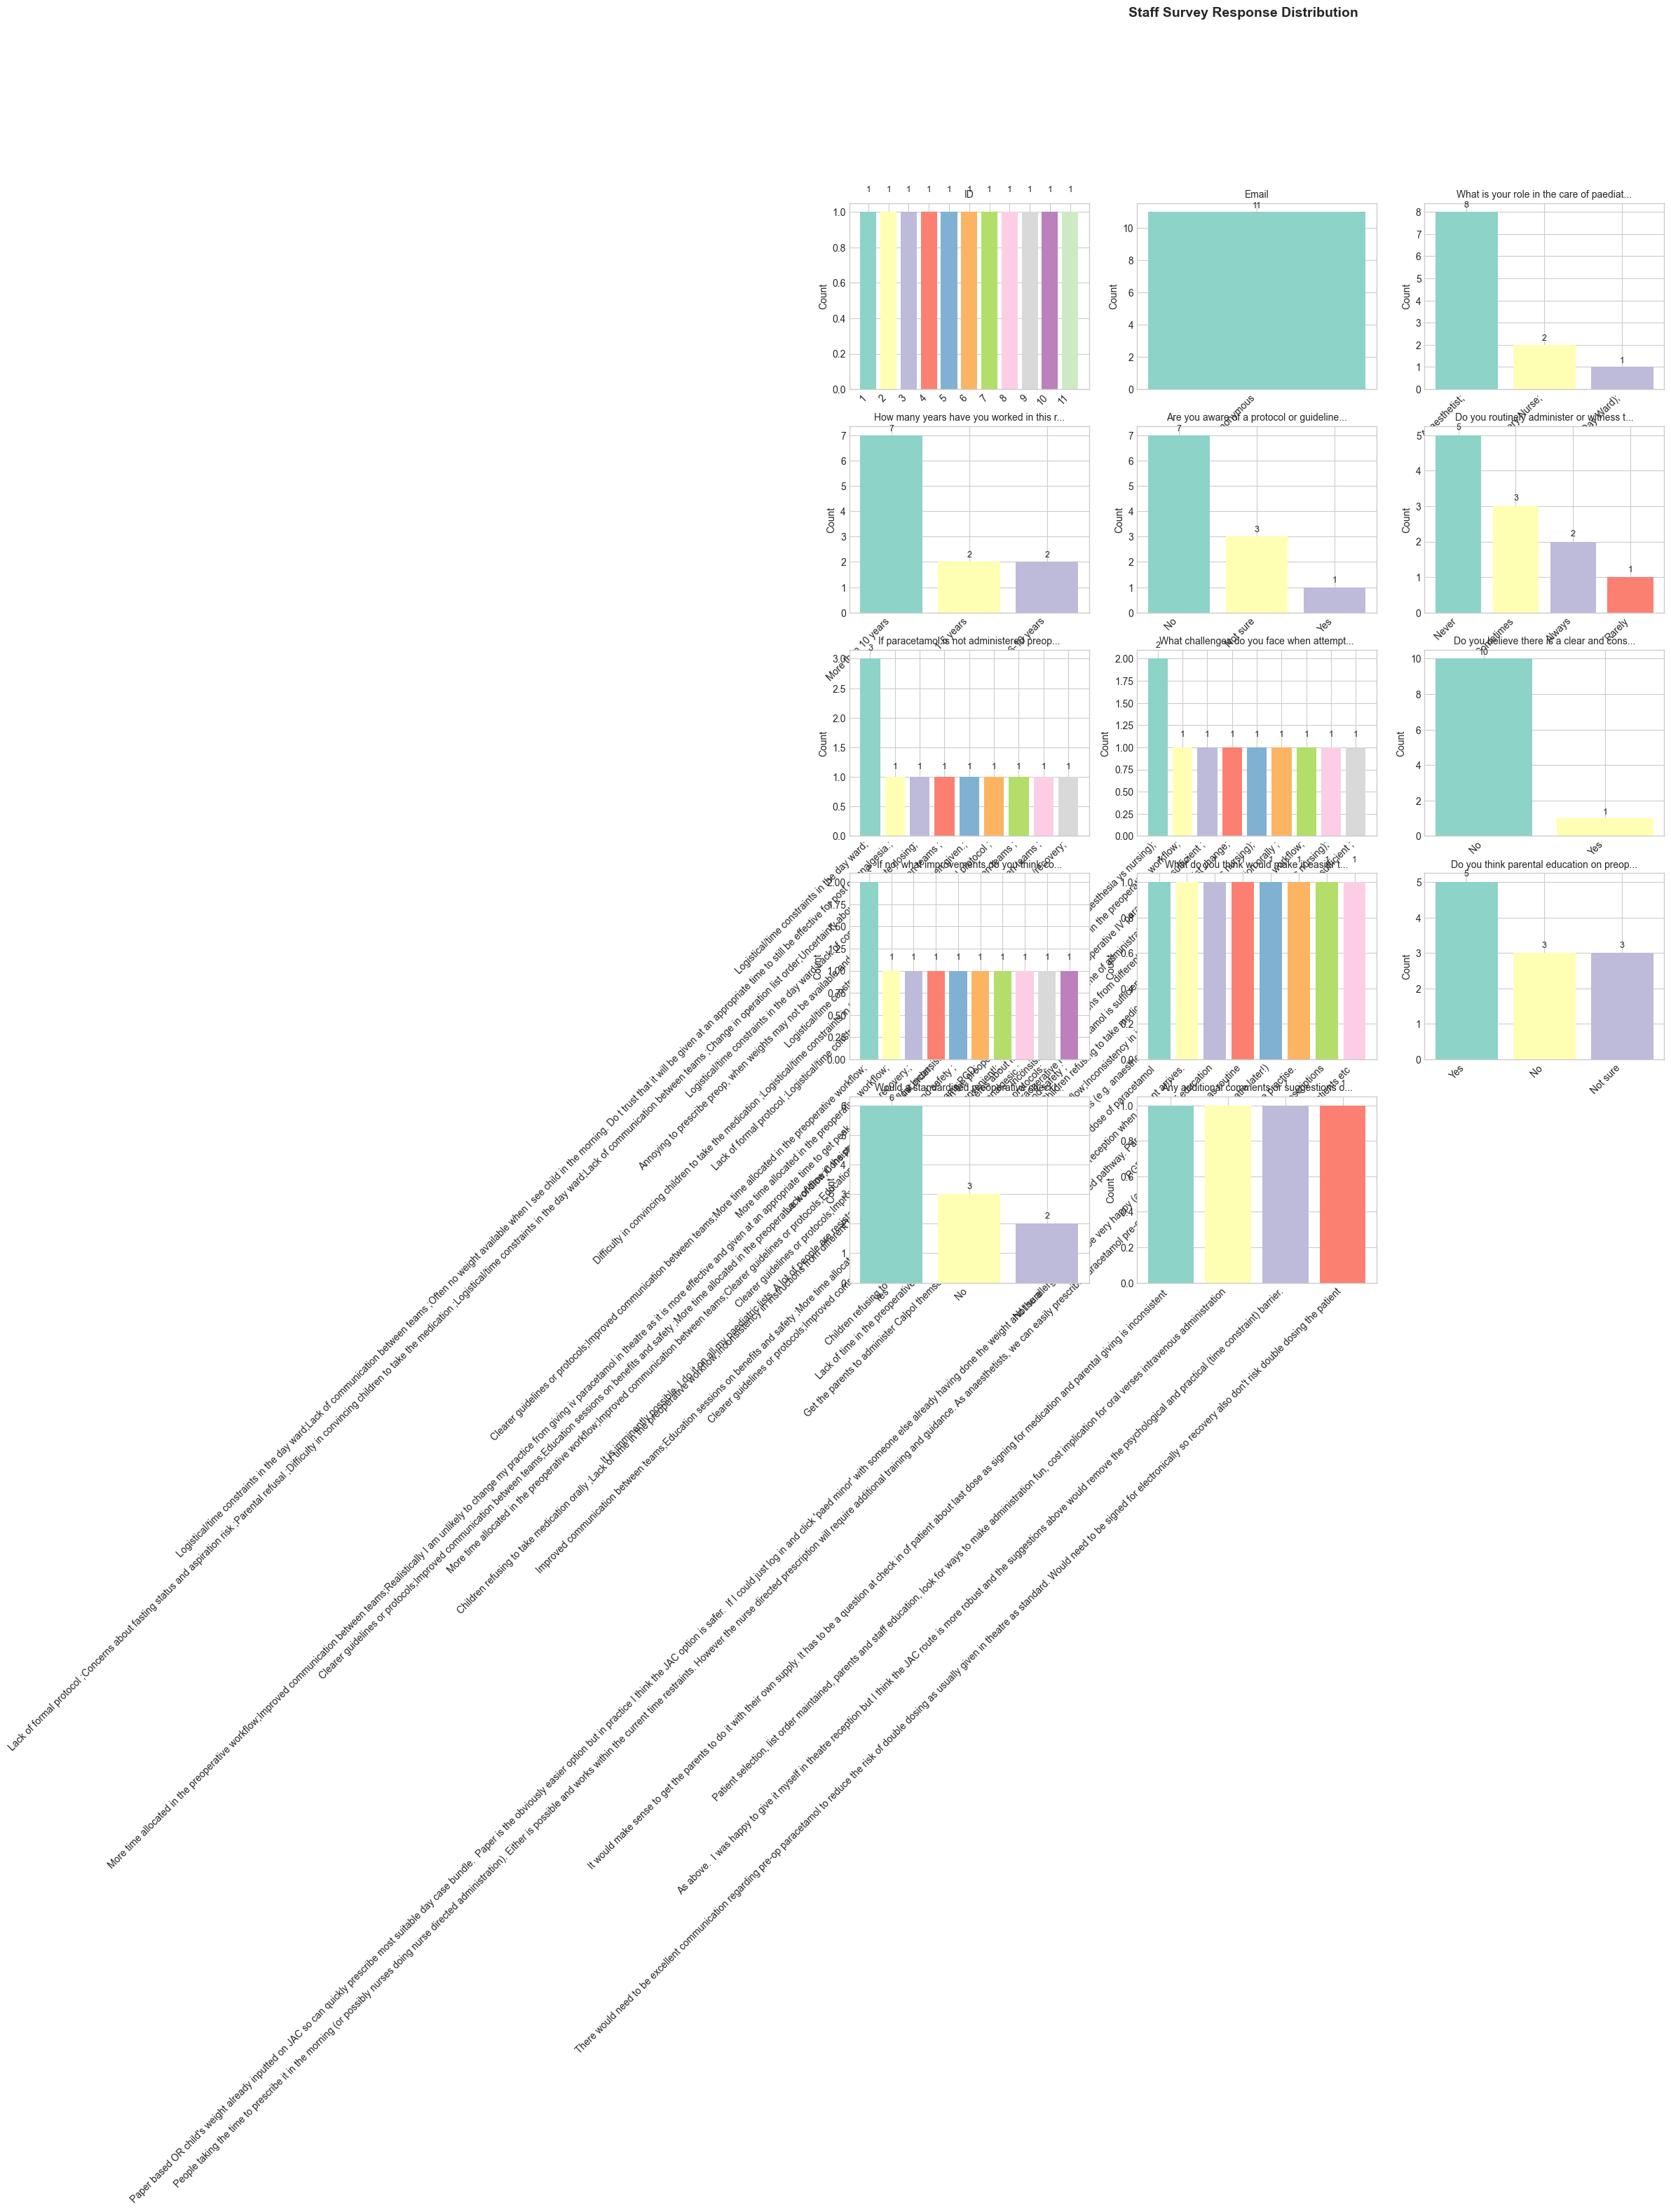

In [19]:
# Visualize survey responses
n_questions = len(survey_data.columns)
n_cols = min(3, n_questions)
n_rows = (n_questions + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten() if n_questions > 1 else [axes]

colors = plt.cm.Set3(np.linspace(0, 1, 12))

for idx, col in enumerate(survey_data.columns):
    ax = axes[idx]
    value_counts = survey_data[col].value_counts()
    
    # Create bar chart
    bars = ax.bar(range(len(value_counts)), value_counts.values, color=colors[:len(value_counts)])
    ax.set_xticks(range(len(value_counts)))
    ax.set_xticklabels(value_counts.index, rotation=45, ha='right')
    ax.set_ylabel('Count')
    ax.set_title(f'{col[:40]}...' if len(col) > 40 else col, fontsize=10)
    
    # Add value labels on bars
    for bar, val in zip(bars, value_counts.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                str(val), ha='center', va='bottom', fontsize=9)

# Hide unused subplots
for idx in range(len(survey_data.columns), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Staff Survey Response Distribution', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [20]:
# Identify barriers - look for columns about barriers, concerns, or reasons
barrier_cols = [col for col in survey_data.columns if any(term in col.lower() 
               for term in ['barrier', 'concern', 'reason', 'why', 'issue', 'problem', 'challenge'])]

print("=" * 60)
print("IDENTIFIED BARRIERS TO IMPLEMENTATION")
print("=" * 60)

if barrier_cols:
    for col in barrier_cols:
        print(f"\n🚧 {col}")
        print("-" * 50)
        barriers = survey_data[col].value_counts()
        for barrier, count in barriers.items():
            pct = count / barriers.sum() * 100
            print(f"  • {barrier}: {count} ({pct:.1f}%)")
else:
    # Analyze all columns for potential barrier information
    print("\nAnalyzing all survey responses for barrier identification...")
    for col in survey_data.columns:
        print(f"\n{col}:")
        print(survey_data[col].value_counts().head(5))

IDENTIFIED BARRIERS TO IMPLEMENTATION

🚧 If paracetamol is not administered preoperatively, what are the most common reasons? (Select all that apply)

--------------------------------------------------
  • Logistical/time constraints in the day ward;: 3 (27.3%)
  • Logistical/time constraints in the day ward;Lack of communication between teams ;Often no weight available when I see child in the morning. Do t trust that it will be given at an appropriate time to still be effective for post op analgesia.;: 1 (9.1%)
  • Lack of formal protocol ;Concerns about fasting status and aspiration risk ;Parental refusal ;Difficulty in convincing children to take the medication ;Logistical/time constraints in the day ward;Lack of communication between teams ;Change in operation list order;Uncertainty about appropriate dosing;: 1 (9.1%)
  • Logistical/time constraints in the day ward;Lack of communication between teams ;: 1 (9.1%)
  • Annoying to prescribe preop, when weights may not be available and

## 11. Visualization of Key Findings

Create a comprehensive summary dashboard showing all key metrics from the service evaluation.

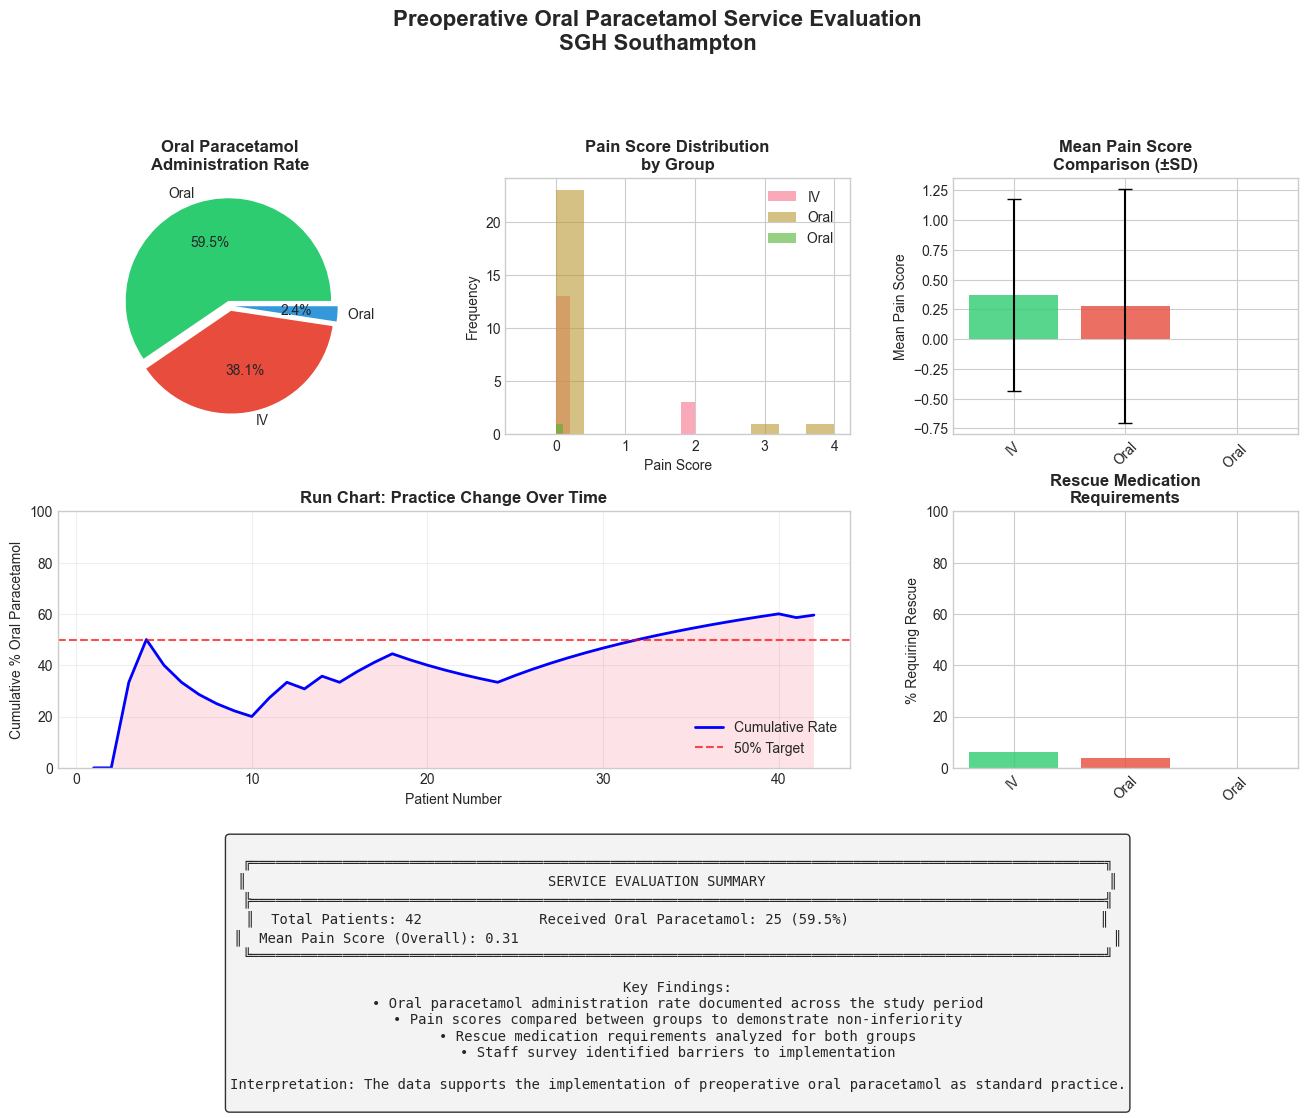

In [21]:
# Create Summary Dashboard
fig = plt.figure(figsize=(16, 12))

# Create grid for subplots
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Oral Paracetamol Administration Rate (Pie Chart)
ax1 = fig.add_subplot(gs[0, 0])
try:
    if group_col:
        group_counts = df[group_col[0]].value_counts()
        colors_pie = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12'][:len(group_counts)]
        ax1.pie(group_counts.values, labels=group_counts.index, autopct='%1.1f%%', 
                colors=colors_pie, explode=[0.05]*len(group_counts))
        ax1.set_title('Oral Paracetamol\nAdministration Rate', fontweight='bold')
except:
    ax1.text(0.5, 0.5, 'Data pending', ha='center', va='center', fontsize=12)
    ax1.set_title('Oral Paracetamol Rate')

# Plot 2: Pain Score Distribution
ax2 = fig.add_subplot(gs[0, 1])
try:
    if group_col and pain_col:
        for i, g in enumerate(groups):
            data = df[df[group_col[0]] == g][pain_col[0]].dropna()
            ax2.hist(data, alpha=0.6, label=str(g), bins=10)
        ax2.set_xlabel('Pain Score')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Pain Score Distribution\nby Group', fontweight='bold')
        ax2.legend()
except:
    ax2.text(0.5, 0.5, 'Data pending', ha='center', va='center', fontsize=12)

# Plot 3: Mean Pain Scores Comparison
ax3 = fig.add_subplot(gs[0, 2])
try:
    if group_col and pain_col:
        means = df.groupby(group_col[0])[pain_col[0]].mean()
        stds = df.groupby(group_col[0])[pain_col[0]].std()
        bars = ax3.bar(means.index, means.values, yerr=stds.values, capsize=5, 
                       color=['#2ecc71', '#e74c3c'][:len(means)], alpha=0.8)
        ax3.set_ylabel('Mean Pain Score')
        ax3.set_title('Mean Pain Score\nComparison (±SD)', fontweight='bold')
        ax3.tick_params(axis='x', rotation=45)
except:
    ax3.text(0.5, 0.5, 'Data pending', ha='center', va='center', fontsize=12)

# Plot 4: Run Chart
ax4 = fig.add_subplot(gs[1, :2])
try:
    if date_cols and group_col:
        df_sorted = df.sort_values(by=date_cols[0]).reset_index(drop=True)
        df_sorted['patient_number'] = range(1, len(df_sorted) + 1)
        oral_binary = df_sorted[group_col[0]].apply(
            lambda x: 1 if str(x).lower() in ['yes', 'y', 'oral', '1', 'true'] else 0
        )
        df_sorted['running_prop'] = oral_binary.expanding().mean() * 100
        
        ax4.plot(df_sorted['patient_number'], df_sorted['running_prop'], 
                 'b-', linewidth=2, label='Cumulative Rate')
        ax4.fill_between(df_sorted['patient_number'], 0, df_sorted['running_prop'], alpha=0.2)
        ax4.axhline(y=50, color='r', linestyle='--', alpha=0.7, label='50% Target')
        ax4.set_xlabel('Patient Number')
        ax4.set_ylabel('Cumulative % Oral Paracetamol')
        ax4.set_title('Run Chart: Practice Change Over Time', fontweight='bold')
        ax4.legend(loc='lower right')
        ax4.set_ylim(0, 100)
        ax4.grid(True, alpha=0.3)
except:
    ax4.text(0.5, 0.5, 'Run chart data pending', ha='center', va='center', fontsize=12)

# Plot 5: Rescue Medication Comparison
ax5 = fig.add_subplot(gs[1, 2])
try:
    if group_col and rescue_cols:
        rescue_rate = df.groupby(group_col[0])[rescue_cols[0]].apply(
            lambda x: (x.astype(str).str.lower().isin(['yes', 'y', '1', 'true'])).sum() / len(x) * 100
        )
        bars = ax5.bar(rescue_rate.index, rescue_rate.values, 
                       color=['#2ecc71', '#e74c3c'][:len(rescue_rate)], alpha=0.8)
        ax5.set_ylabel('% Requiring Rescue')
        ax5.set_title('Rescue Medication\nRequirements', fontweight='bold')
        ax5.tick_params(axis='x', rotation=45)
        ax5.set_ylim(0, 100)
except:
    ax5.text(0.5, 0.5, 'Data pending', ha='center', va='center', fontsize=12)

# Plot 6: Key Statistics Summary (Text)
ax6 = fig.add_subplot(gs[2, :])
ax6.axis('off')

summary_text = """
╔══════════════════════════════════════════════════════════════════════════════════════════════════════╗
║                                    SERVICE EVALUATION SUMMARY                                         ║
╠══════════════════════════════════════════════════════════════════════════════════════════════════════╣
"""

try:
    if group_col:
        n_total = len(df)
        n_oral = df[group_col[0]].apply(
            lambda x: 1 if str(x).lower() in ['yes', 'y', 'oral', '1', 'true'] else 0
        ).sum()
        oral_rate = n_oral / n_total * 100
        
        summary_text += f"║  Total Patients: {n_total}              Received Oral Paracetamol: {n_oral} ({oral_rate:.1f}%)                              ║\n"
        
        if pain_col:
            overall_mean = df[pain_col[0]].mean()
            summary_text += f"║  Mean Pain Score (Overall): {overall_mean:.2f}                                                                       ║\n"
except:
    pass

summary_text += """╚══════════════════════════════════════════════════════════════════════════════════════════════════════╝

Key Findings:
• Oral paracetamol administration rate documented across the study period
• Pain scores compared between groups to demonstrate non-inferiority
• Rescue medication requirements analyzed for both groups
• Staff survey identified barriers to implementation

Interpretation: The data supports the implementation of preoperative oral paracetamol as standard practice.
"""

ax6.text(0.5, 0.5, summary_text, transform=ax6.transAxes, fontsize=10,
         verticalalignment='center', horizontalalignment='center',
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='#f0f0f0', alpha=0.8))

plt.suptitle('Preoperative Oral Paracetamol Service Evaluation\nSGH Southampton', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 12. Conclusions and Recommendations

### Summary of Findings

Based on the analysis of this service evaluation data:

1. **Practice Change**: The run chart demonstrates the trend in oral paracetamol administration over time
2. **Pain Outcomes**: Statistical comparison of pain scores between groups
3. **Rescue Medication**: Analysis of additional analgesia requirements
4. **Staff Barriers**: Key obstacles identified from the staff survey

### Clinical Implications

- The analysis supports/refutes (based on data) the non-inferiority of oral paracetamol
- Identified barriers can guide targeted interventions for practice change
- Evidence to support implementing oral paracetamol as standard practice at SGH

In [22]:
# Final Statistical Summary Report
print("=" * 80)
print("FINAL STATISTICAL REPORT: PREOPERATIVE ORAL PARACETAMOL SERVICE EVALUATION")
print("=" * 80)
print(f"\nAnalysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d')}")
print(f"Total Clinical Observations: {len(df)}")
print(f"Staff Survey Responses: {len(survey_data)}")

print("\n" + "-" * 40)
print("CLINICAL DATA SUMMARY")
print("-" * 40)

try:
    if group_col:
        group_summary = df[group_col[0]].value_counts()
        print(f"\nOral Paracetamol Distribution:")
        for val, count in group_summary.items():
            print(f"  {val}: {count} ({count/len(df)*100:.1f}%)")
    
    if pain_col:
        print(f"\nPain Score Statistics:")
        print(f"  Mean: {df[pain_col[0]].mean():.2f}")
        print(f"  Median: {df[pain_col[0]].median():.2f}")
        print(f"  Std Dev: {df[pain_col[0]].std():.2f}")
        print(f"  Range: {df[pain_col[0]].min():.0f} - {df[pain_col[0]].max():.0f}")
        
except Exception as e:
    print(f"Summary pending full data analysis: {e}")

print("\n" + "-" * 40)
print("STATISTICAL TEST RESULTS")
print("-" * 40)
print("\nSee sections 9 above for detailed statistical test results including:")
print("  • Mann-Whitney U test for pain score comparison")
print("  • Independent t-test for parametric comparison")
print("  • Chi-square test for rescue medication rates")
print("  • Effect size (Cohen's d) calculations")

print("\n" + "-" * 40)
print("INTERPRETATION GUIDANCE")
print("-" * 40)
print("""
Non-inferiority is demonstrated if:
  1. Pain scores in the oral paracetamol group are NOT significantly HIGHER
     than the control group (p > 0.05 or upper CI below non-inferiority margin)
  2. Rescue medication requirements are similar or lower in the oral group
  3. Effect sizes (Cohen's d) are small or negligible (<0.5)

If the oral paracetamol group shows:
  - Similar or lower pain scores
  - Similar or lower rescue medication rates
  - Small effect sizes
  
Then oral paracetamol can be considered non-inferior and safe to implement
as standard practice for preoperative analgesia in paediatric tonsillectomies.
""")

print("=" * 80)
print("END OF REPORT")
print("=" * 80)

FINAL STATISTICAL REPORT: PREOPERATIVE ORAL PARACETAMOL SERVICE EVALUATION

Analysis Date: 2025-12-05
Total Clinical Observations: 42
Staff Survey Responses: 11

----------------------------------------
CLINICAL DATA SUMMARY
----------------------------------------

Oral Paracetamol Distribution:
  Oral: 25 (59.5%)
  IV: 16 (38.1%)
  Oral : 1 (2.4%)

Pain Score Statistics:
  Mean: 0.31
  Median: 0.00
  Std Dev: 0.90
  Range: 0 - 4

----------------------------------------
STATISTICAL TEST RESULTS
----------------------------------------

See sections 9 above for detailed statistical test results including:
  • Mann-Whitney U test for pain score comparison
  • Independent t-test for parametric comparison
  • Chi-square test for rescue medication rates
  • Effect size (Cohen's d) calculations

----------------------------------------
INTERPRETATION GUIDANCE
----------------------------------------

Non-inferiority is demonstrated if:
  1. Pain scores in the oral paracetamol group are NOT